# Figure 4: Spatial Frequency Tuning Curves

## Setup
Import libraries and configure matplotlib for consistent figure styling.

In [17]:
import sys
sys.path.append('..')
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sfp_nsdsyn import *

rc = {'text.color': 'black',
      'axes.labelcolor': 'black',
      'xtick.color': 'black',
      'ytick.color': 'black',
      'axes.edgecolor': 'black',
      'font.family': 'Helvetica',
      'axes.linewidth': 1,
      'axes.labelpad': 6,
      'xtick.major.pad': 10,
      'xtick.major.width': 1,
      'ytick.major.width': 1,
      'lines.linewidth': 1,
      'font.size': 12,
      'axes.titlesize': 12,
      'axes.labelsize': 12,
      'xtick.labelsize': 12,
      'ytick.labelsize': 12,
      'legend.title_fontsize': 11,
      'legend.fontsize': 11,
      'figure.titlesize': 12,
      'figure.dpi': 72 * 3,
      'savefig.dpi': 72 * 4
      }
mpl.rcParams.update(rc)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters
Define output directories, ROI list, model hyperparameters, eccentricity binning, subject lists, and color palette.

In [18]:
output_dir = '/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir = os.path.join(output_dir, 'figures', 'sfp_model', 'results_1D')
roi_list = ['V1', 'V2', 'V3']
lr = 0.005
max_epoch = 8000
voxels = 'pRFcenter'
subj = 'subj08'
e1, e2 = 0.5, 4
enum = 7

nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1, 9)]
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)
bins_to_plot = [bin_labels[k] for k in [0, 6]]

a = [3, 2, 0]
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in a]


## Subject-Level Tuning Curves
Plot spatial frequency tuning curves for an example subject (subj08) across V1, V2, and V3.

### Load Subject Data
Load voxel-level data for subj08, filter out mixture stimuli, bin by eccentricity, and compute summary statistics. Also load the fitted 1D log-Gaussian model parameters.

In [19]:
f = []
for roi in roi_list:
    f.append(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'model',
                          f'dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}_tavg-False.csv'))
subj_data_df = utils.load_dataframes(f)
subj_data_df = subj_data_df.query('names != "mixtures"')
subj_data_df['ecc_bin'] = tuning.bin_ecc(subj_data_df['eccentricity'], bin_list=bin_list, bin_labels=bin_labels)
subj_data_df = tuning.summary_stat_for_ecc_bin(subj_data_df,
                                               to_group=['sub', 'ecc_bin', 'freq_lvl', 'names', 'vroinames', 'task', 'phase_idx'],
                                               to_bin=['betas', 'local_sf'],
                                               central_tendency='mean')

args = ['sub', 'class', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
pt_file_list = []
for roi, curbin, stim_class in itertools.product(roi_list, range(enum), ['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
subj_tuning_df = tuning.load_all_models(pt_file_list, *args)

### Plot Subject-Level Tuning Curves
Plot fitted tuning curves with error bars for the lowest and highest eccentricity bins.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


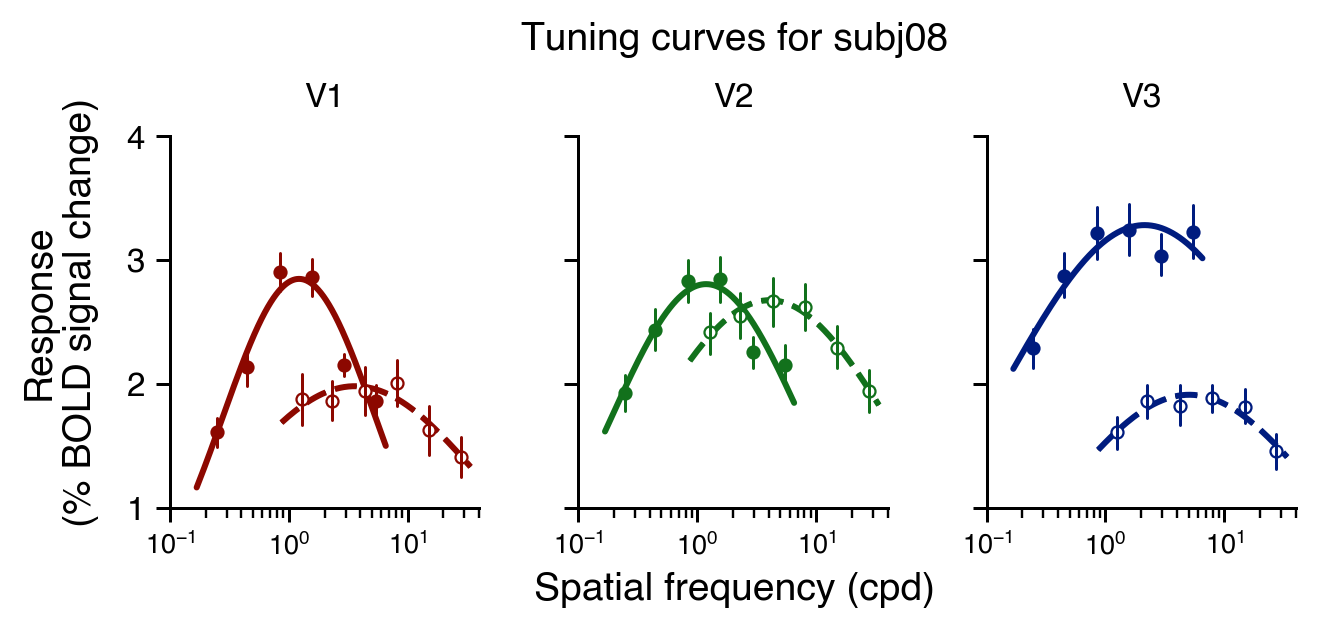

In [20]:
fig, axes = vis1D.plot_tuning_curves_NSD_with_errorbar(subj_data_df,
                                                       subj_tuning_df,
                                                       y='betas',
                                                       bins_to_plot=bins_to_plot,
                                                       pal=roi_pal,
                                                       normalize=False,
                                                       errorbar=True,
                                                       title='Tuning curves for subj08',
                                                       save_path=os.path.join(fig_dir, 'nsdsyn_subj-subj08_tuning_curves_normalize-False.svg'))

## Group-Level Average Tuning Curves
Plot spatial frequency tuning curves averaged across all 8 NSD subjects for V1, V2, and V3.

### Load Group Data
Load pre-binned data and fitted model parameters for all 8 subjects across V1, V2, and V3.

In [21]:
f = []
for subj_id, roi in itertools.product(nsd_subj_list, roi_list):
    file_name = f'e1-{e1}_e2-{e2}_nbin-{enum}_sub-{subj_id}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'binned', file_name))
group_data_df = utils.load_dataframes(f)
group_data_df = group_data_df.groupby(['sub', 'ecc_bin', 'vroinames', 'freq_lvl']).mean().reset_index()

args = ['sub', 'class', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
pt_file_list = []
for subj_id, roi, curbin in itertools.product(nsd_subj_list, roi_list, range(enum)):
    file_name = f'model-params_class-avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_sub-{subj_id}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
group_tuning_df = tuning.load_all_models(pt_file_list, *args)

### Plot Group-Level Average Tuning Curves
Plot average tuning curves with error bars across subjects for the lowest and highest eccentricity bins. Error bars represent 68% CI bootstrapped across subjects.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


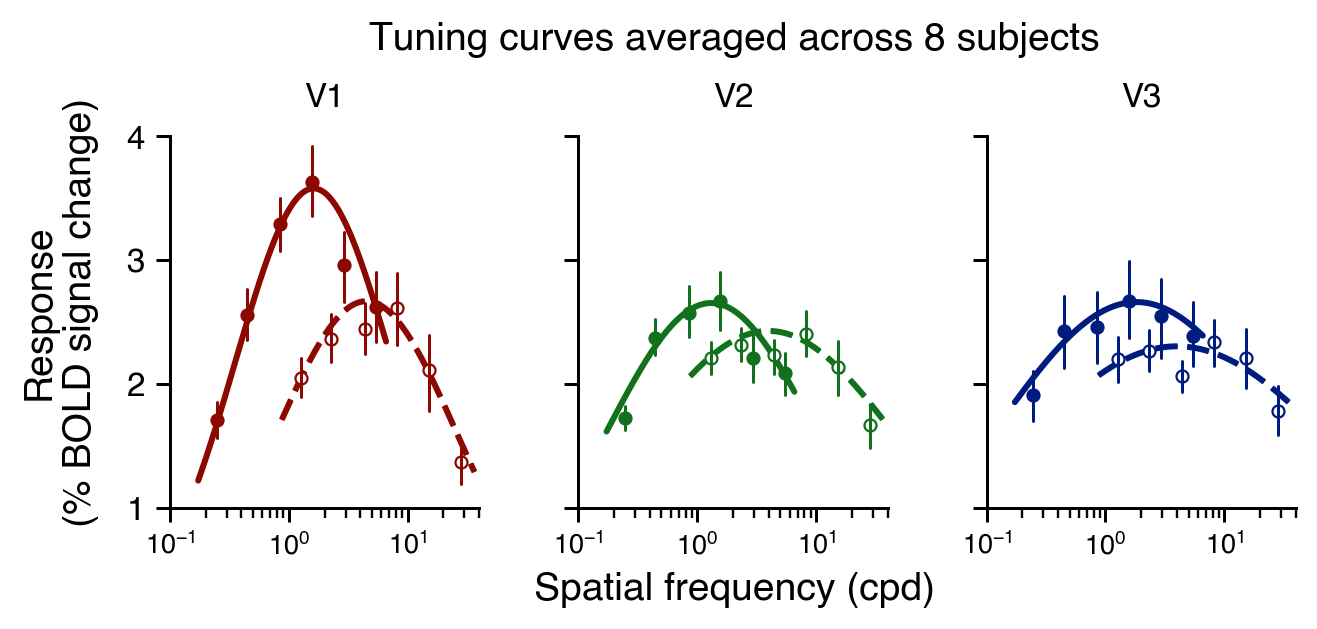

In [22]:
fig, axes = vis1D.plot_average_tuning_curves_NSD_with_errorbar(group_data_df, group_tuning_df,
                                                               y='betas',
                                                               bins_to_plot=bins_to_plot,
                                                               normalize=False,
                                                               errorbar=True,
                                                                title='Tuning curves averaged across 8 subjects',
                                                               pal=roi_pal,
                                                               save_path=os.path.join(fig_dir, 'nsdsyn_subj-avg_tuning_curves_normalize-False.svg'))